In [91]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import matplotlib.gridspec as gridspec
import pandas as pd

# En las siguientes celdas se cargan los datos siguiendo el tutorial

In [92]:
# cargar datos
with open("shipsnet.json", "r") as f:
    dataset = json.load(f)
print(dataset.keys())

dict_keys(['data', 'labels', 'locations', 'scene_ids'])


In [93]:
# llevar las imagenes aplanadas a 80x80x3
data = np.array(dataset['data']).astype('uint8')
data = data.reshape(-1,3,80,80).transpose([0,2,3,1])
labels =  np.array(dataset['labels'])

print(f"Dimensión: {data.shape}")

# llevamos las imágenes RGB a escala de grises
data_gray = np.array([color.rgb2gray(i) for i in data])
print(f"Dimensión: {data_gray.shape}")

Dimensión: (4000, 80, 80, 3)
Dimensión: (4000, 80, 80)


In [94]:
# extrae hog features y hog transformation para cada imagen
ppc = 20
hog_images = []
hog_features = []
for image in data_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc), cells_per_block=(1, 1),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)
hog_features = np.array(hog_features)
hog_images = np.array(hog_images)

hog_features.shape


(4000, 128)

In [95]:
print(np.array(dataset["labels"]).size)
print(data.shape)

4000
(4000, 80, 80, 3)


# Se discrimina entre datos de entrenamiento, validación y para testear

$70$% entrenamiento, $15$% validación y $15$% para testear

In [96]:
x_train, x_resto, y_train, y_resto = train_test_split(hog_features, labels, test_size=0.3, random_state=12)
x_val, x_test, y_val, y_test = train_test_split(x_resto, y_resto, test_size=0.5, random_state=12)
N_train = len(x_train)
N_val = len(x_val)
N_test = len(x_test)

# Funciones útiles

In [97]:
def sigma(w, x):
    """
    Calcula sigma(w.x)
    w y x son arreglos numéricos de igual largo.
    """
    return 1 / (1 + np.exp(-np.dot(w, x)))

def logVerTrain(w):
    """
    Calcula log-verosimilitud de w con datos de entrenamiento.
    w: arreglo numérico.
    """
    N = len(w)
    return sum(y_train[i] * np.log(sigma(w, x_train[i])) + 
                                    (1 - y_train[i]) * np.log(1 - sigma(w, x_train[i])) for i in range(N)) 

def logVerVal(w):
    """
    Calcula log-verosimilitud de w con datos de validación.
    w: arreglo numérico.
    """
    N = len(w)
    return sum(y_val[i] * np.log(sigma(w, x_val[i])) + (1 - y_val[i]) * np.log(1 - sigma(w, x_train[i]))                     for i in range(N))

def logVerTest(w):
    """
    Calcula log-verosimilitud de w con datos de testeo.
    w: arreglo numérico.
    """
    N = len(w)
    return sum(y_test[i] * np.log(sigma(w, x_test[i])) + (1 - y_test[i]) * np.log(1 - sigma(w, x_test[i]))                 for i in range(N)) 

# Clase que hará la regresión 

El método $\texttt{optiGSD}(genMax, \eta)$ realiza la optimización de la función log-ver, que se calcula en base a los datos de entrenamiento, con el método del gradiente estocástico.

\begin{align}
    l(w) &= \sum_{i=1}^{N} y_i\sigma(w^{T}x_i) + (1-y_i)(1-\sigma(w^{T}x_i))\\
    \sigma(x) &= \frac{1}{1 + e^{-x}}\\
    \nabla l(w) = \sum_{i=1}^{N} 
\end{align}
El método $\texttt{predict(x)}$ retornará en valor $p(\mathcal{C}_1|x)$


In [107]:
np.random.seed(12)
class RegLog:
    def __init__(self, xData, yData):
        
        self.xData = xData
        self.yData = yData
        self.N = len(yData)
        self.dim = len(xData[0])
        self.umbral = 0.5
        
    def sigma(self, w, i):
        """
        Método que calcula sigma(w.x[i])
        w: arreglo de largo N.
        i: índice del vector de interés.
        """
        return 1 / (1 + np.exp(-np.dot(w, self.xData[i])))
    
    def train(self, genMax, eta):
        """
        Maximiza versimilitud con GSD.
        genMax: Número máximo de generaciones.
        eta: learning rate.
        return: 3 arreglos que guardan la función de verosimilitud.
        """
        # Arreglos que guardarán las maximas verosimilitudes alcanzadas en cada época.
        train = []
        val = []
        test =[]
        # Optimización.
        w = np.zeros(self.dim)
        ti = time.time()
        # Realiza genMax pasadas por los datos.
        for i in range(genMax):
            ind = np.arange(self.N)
            np.random.shuffle(ind)
            for j in ind:
                w = w + eta * (self.yData[j] - self.sigma(w, j)) * self.xData[j]
            # Guardamos datos asociados a cada época.
            train.append(logVerTrain(w))
            val.append(logVerVal(w))
            test.append(logVerTest(w))

        tf = time.time()    
        print("Generaciones: " + str(genMax) + ', eta: ' +  str(eta) +", tiempo (s): ", tf - ti)
        self.w = w
        return [np.array(train), np.array(val), np.array(test)]
    
    def predict(self, x):
        """
        Calcula la probabilidad de bote y retorna 1 si esta es mayor a p con p el umbral en (0,1)
        x: arreglo de tamaño la dimensión de los datos x (self.dim).       
        """

        return 1 / (1 + np.exp(-np.dot(self.w, x))) >= self.umbral
    
    def resetWeight(self):
        """
        Resetea el peso.
        """
        self.w = np.zeros(self.dim)
        
    def setUmbral(self, p):
        """
        Setter del umbral de decisión
        """
        self.umbral = p
        
    def plotUmbralCerteza(self, x, y):
        """
        Método que plotes umbral vs porcentaje de certeza sobre el set de datos (x,y)
        (x,y): Set de datos (feature, class).
        """
        N = len(y)
        d = 0.1
        porcentaje = []
        for p in np.arange(0, 1 + d, d):
            self.setUmbral(p)
            errorVal = [np.abs(self.predict(x[i]) - y[i]) for i in range(N)]
            porcentaje.append((N - np.count_nonzero(errorVal)) / N)
        font = {'family': 'serif',
                'color':  'black',
                'weight': 'normal',
                'size': 16,
                }
        plt.plot(np.arange(0, 1 + d, d), porcentaje, 'o')
        plt.title('Porcentaje de certeza sobre datos de validación', fontdict=font)
        plt.ylabel('Certeza (%)')
        plt.xlabel('Umbral')
        plt.grid()
        plt.show()
              
            


# Guardamos los resultados de la log-ver y el $\omega$ 

In [99]:
# Se crea objeto encargado de la regresión.
genMax = 100
reg = RegLog(x_train, y_train)
N_train = reg.N
eta = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
A = [[], [], [], [], [], []]
# Se guardan las max log-verosimilitud
for i in range(6):
    A[i] = reg.train(genMax, eta[i])
    reg.resetWeight()
  

Generaciones: 100, eta: 0.001, tiempo (s):  17.05381202697754
Generaciones: 100, eta: 0.01, tiempo (s):  18.281692504882812
Generaciones: 100, eta: 0.05, tiempo (s):  14.19814682006836
Generaciones: 100, eta: 0.1, tiempo (s):  16.67298722267151
Generaciones: 100, eta: 0.2, tiempo (s):  17.544004917144775
Generaciones: 100, eta: 0.5, tiempo (s):  17.564815521240234


# Se generan gráficas.

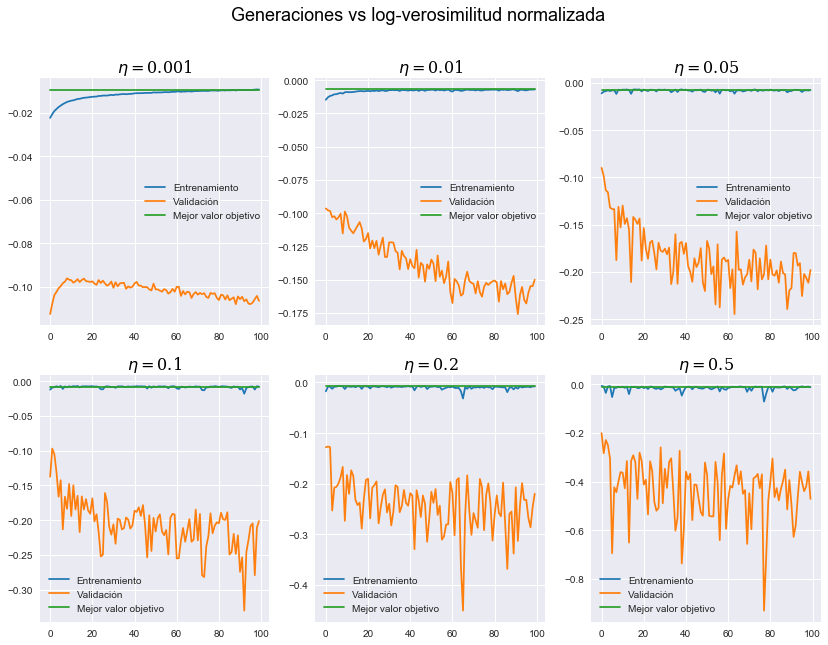

<Figure size 1440x288 with 0 Axes>

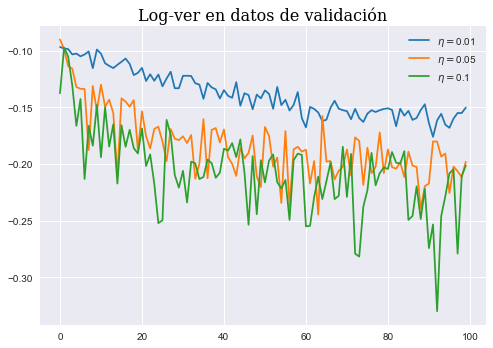

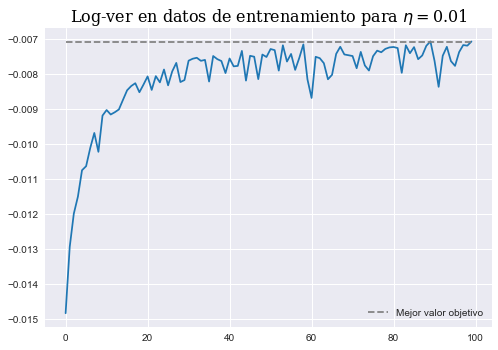

In [100]:
plt.style.use(u'seaborn-notebook')
# Plots.
def plotLogVerVsGen():
    """
    Plotea la log-verosimilitud en función de la cantidad de generaciones.
    """
    k = len(A[0][0])
    x = np.arange(k)
    # axs.
    font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
    fig, axs = plt.subplots(2, 3, figsize=(14,10))
    fig.suptitle('Generaciones vs log-verosimilitud normalizada', fontsize=18, color='black')
    plt.figure(figsize=(20,4))

    # Generar plots de todo junto, varios eta.
    
    for i in [0, 1]:
        for j in [0, 1, 2]:
            axs[i, j].plot(x, A[i * 3 + j][0] * (1 / N_train), label='Entrenamiento')
            axs[i, j].plot(x, A[i * 3 + j][1] * (1 / N_val), label='Validación')
            axs[i, j].plot(x, np.ones(100) * A[i * 3 + j][0][100 - 1] * (1 / N_train), label='Mejor valor objetivo')
            axs[i, j].set_title(r'$\eta=$'+str(eta[i * 3 + j]), fontdict=font)
            axs[i, j].legend()
            axs[i, j].grid()
    
    plt.show()
    
    # Por separado
    """
    for i in [1, 2, 3]:
        plt.plot(x, A[i][0] * (1 / N_train), label='Entrenamiento')
        plt.plot(x, A[i][1] * (1 / N_val), label='Validación')
        plt.plot(x, np.ones(100) * A[i][0][100 - 1] * (1 / N_train), label='Mejor valor objetivo')
        plt.title(r'$\eta=$'+str(eta[i]), fontdict=font)
        plt.legend()
        plt.grid()
        plt.show()
    """
    # Sólo log-ver en datos de vaildación
    plt.title('Log-ver en datos de validación', fontdict=font)
    
    for i in [1, 2, 3]:
        plt.plot(x, A[i][1] * (1 / N_val), label=r'$\eta=$'+str(eta[i]))
        
    plt.grid()
    plt.legend()
    plt.show()
    # Sólo log-ver en datos de entrenamiento para eta[1]
    
    plt.title(r'Log-ver en datos de entrenamiento para $\eta=$'+str(eta[1]), fontdict=font)
    
    plt.plot(x, A[1][0] * (1 / N_train))
    plt.plot(x, np.ones(100) * A[1][0][100 - 1] * (1 / N_train), '--', color='grey', label='Mejor valor objetivo')
    plt.legend()
        
    plt.grid()
    plt.show()
    

plotLogVerVsGen()

# Elección de hiperparámetros
Desde ahora se tomará $\eta = 0.01$ y $e=30$

In [108]:
# Se crea objeto encargado de la regresión.
genMax = 40
eta = 0.01
reg = RegLog(x_train, y_train)
N_train = reg.N
# Se entrena reg.
B = reg.train(genMax, eta)
pesoRL = reg.w
bRL = np.ln(0.)

Generaciones: 40, eta: 0.01, tiempo (s):  6.6452109813690186


# Predicciones sobre el set de testeo y validación

El error será simplemente $|x-\texttt{predict}(x)|$, dónde $\texttt{predict}(x)$ es la predicción del método. El error será un número entre 0 y 1. Se mostrará en gráfico de barras la cantidad de predicciones correctas e incorrectas. También definimos el porcentaje de certeza como sigue:

\begin{equation}
    p = \frac{\textit{predicciones correctas}}{|D|}
\end{equation}


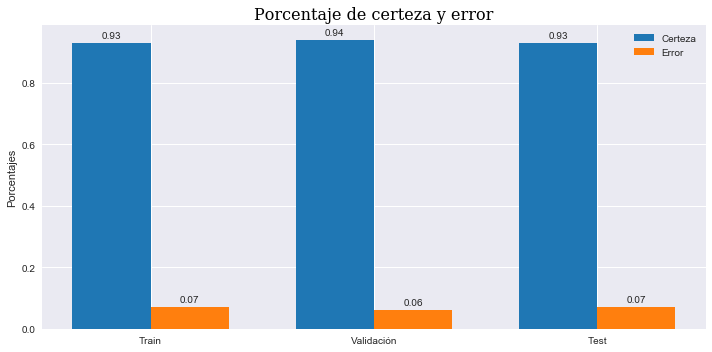

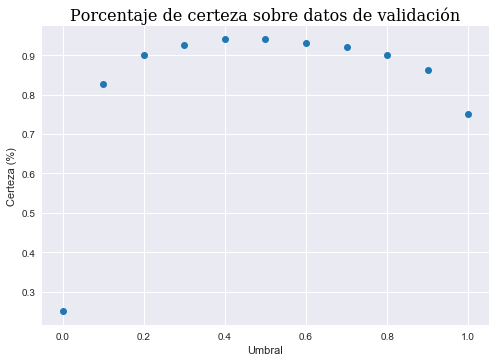

In [128]:
# Seteamos el umbral
reg.setUmbral(0.5)
# Función que plotes porcentajes de certeza
def plotBar(reg):
    """
    Método que plotea porcentajes de certeza.
    reg: objeto clasificador que cuente con el método predict.
    """
    # Errores
    errorVal = [np.abs(reg.predict(x_val[i]) - y_val[i]) for i in range(N_val)]
    errorTest = [np.abs(reg.predict(x_test[i]) - y_test[i]) for i in range(N_test)]
    errorTrain = [np.abs(reg.predict(x_train[i]) - y_train[i]) for i in range(N_train)]

    # Porcentajes de certeza
    pTrain = (N_train - np.count_nonzero(errorTrain)) / N_train
    pVal = (N_val - np.count_nonzero(errorVal)) / N_val
    pTest = (N_test - np.count_nonzero(errorTest)) / N_test
    
    # Plots

    font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }

    labels = ['Train', 'Validación', 'Test']
    pCorrectos = np.array([pTrain, pVal, pTest])
    pIncorrectos = 1 - pCorrectos

    x = np.arange(len(labels)) 
    width = 0.35

    fig, ax = plt.subplots(figsize=(10,5))
    rects1 = ax.bar(x - width/2, pCorrectos, width, label='Certeza')
    rects2 = ax.bar(x + width/2, pIncorrectos, width, label='Error')

    ax.set_ylabel('Porcentajes')
    ax.set_title('Porcentaje de certeza y error', fontdict=font)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid()
    ax.legend()

    for rects in [rects1, rects2]:
        for rect in rects:
            height = np.round(rect.get_height(),2)
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom')


    fig.tight_layout()

    plt.show()


# Gráfico de barras.
plotBar(reg)
# Umbral vs certeza.
reg.plotUmbralCerteza(x_val, y_val)

# Discriminante lineal de Fisher

Usaremos la clasificación lineal de la forma $x\in\mathcal{C}_1$ si $a^{T}x\ge -b$ y $x\in\mathcal{C}_2$ en caso contrario. Dónde los parámetros, según la teoría, se calculan como sigue

\begin{align}
    a &\propto S_w^{-1} (\mu_1 - \mu_2)\\
    S_w &= \sum_{n\in\mathcal{C}_1} (x_n-\mu_1)(x_n-\mu_1)^{T} + \sum_{n\in\mathcal{C}_2} (x_n-\mu_2)
    (x_n-\mu_2)^{T}\\
    \mu_k &= \frac{1}{|\mathcal{C}_k|} \sum_{n\in\mathcal{C}_k} x_n\\
    -b &= a^{T}\frac{1}{2}(\mu_1 + \mu_2)
\end{align}

In [130]:
class Fisher:
    def __init__(self, xData, yData):
        self.xData = xData
        self.yData = yData
        self.N = len(xData)
        self.dim = len(xData[0])
        self.a = 0
        self.b = 0
    def train(self):
        """
        Calcula los parámetros y los guarda.
        """
        xData = self.xData
        yData = self.yData
        # Calculos de promedios
        indS = np.where(yData == 1)[0]
        mS = (1 / len(indS)) * sum(xData[i] for i in indS)
        indNS = np.where(yData == 0)[0]
        mNS = (1 / len(indNS)) * sum(xData[i] for i in indNS)
        # Matriz Sw
        Sw_1 = sum(np.dot( (xData[i] - mS).reshape((self.dim,1)), (xData[i] - mS).reshape((1, self.dim)))                        for   i in indS) 
        Sw_2 = sum(np.dot((xData[i] - mNS).reshape((self.dim,1)), (xData[i] - mNS).reshape((1, self.dim)))                   for i in indS)
        Sw = Sw_1 + Sw_2
        self.a = np.dot(np.linalg.inv(Sw), (mS  - mNS))
        self.b = - (1 / 2) * np.dot(self.a , mS + mNS) 

    def predict(self, x):
        """
        Entrega la clase (0, 1) a la que pertenece x según Fisher
        x: arreglo numérico de dimensión self.dim
        return: 1 si es un barco, 0 si no.
        """
        return np.dot(self.a, x) >= -self.b
        



# Predicciones sobre el set de testeo y validación

El error será simplemente $|x-\texttt{predict}(x)|$, dónde $\texttt{predict}(x)$ es la predicción del método. También se presenta un gráfico de barras con los porcentajes de certeza.

Norma parámetro a:  0.007039827926938778
Parámetro b:  -0.012257255654256458


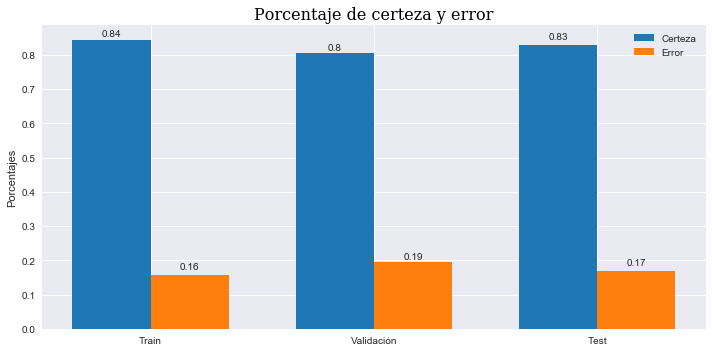

In [129]:
fish = Fisher(x_train, y_train)
# Se entrena el modelo.
fish.train()
aFish = fish.a
bFish = fish.b
print('Parámetro b: ', bFish)
plotBar(fish)